In [113]:
#基本是Yves Hilpisch大神的代码，略作一点修改
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [114]:
'''蒙特卡洛方法产生模拟路径'''
def CIR_generate_paths(x0, kappa, theta, sigma, T, M, I, x_disc='exact'):
    dt = T / M
    x = np.zeros((M + 1, I), dtype=np.float)
    x[0] = x0
    xh = np.zeros_like(x)
    xh[0] = x0
    ran = np.random.standard_normal((M + 1, I))
    #高精度模拟
    if x_disc is 'exact':
        d = 4 * kappa * theta / sigma ** 2 #自由度
        c = (sigma ** 2 * (1 - math.exp(-kappa * dt))) / (4 * kappa) #公式1中卡方随机变量前的系数
        if d > 1:
            for t in range(1, M + 1):
                l = x[t - 1] * math.exp(-kappa * dt) / c
                chi = np.random.chisquare(d - 1, I) #计算卡方随机变量
                x[t] = c * ((ran[t] + np.sqrt(l)) ** 2 + chi)
        else:
            for t in range(1, M + 1):
                l = x[t - 1] * math.exp(-kappa * dt) / c
                N = np.random.poisson(l / 2, I)
                chi = np.random.chisquare(d + 2 * N, I) #计算卡方随机变量
                x[t] = c * chi
    #低精度模拟
    else:
        for t in range(1, M + 1):
            xh[t] = (xh[t - 1] + kappa * (theta - np.maximum(0, xh[t - 1])) *
                     dt + np.sqrt(np.maximum(0, xh[t - 1])) *
                     sigma * ran[t] * math.sqrt(dt)) #公式2
            x[t] = np.maximum(0, xh[t]) #公式3
    return x

In [115]:
'''绘制利率路径'''
def plot_paths():
    plt.figure(figsize=(9, 5))
    plt.plot(range(len(r)), r[:, :100])
    plt.xlabel('time step')
    plt.ylabel('short rate')
    plt.show()

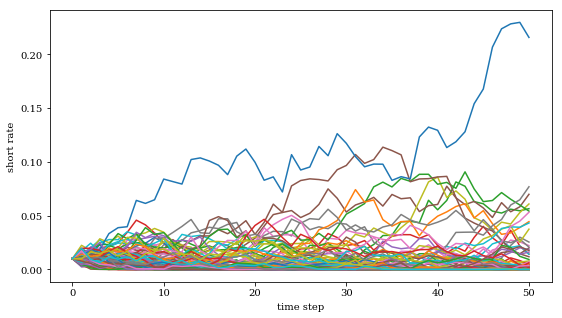

In [116]:
r0, kappa_r, theta_r, sigma_r = [0.01, 0.1, 0.03, 0.2]
T = 2.0  # time horizon
M = 50  # time steps
dt = T / M
I = 50000  # number of MCS paths
#np.random.seed(50000)  # seed for RNG

r = CIR_generate_paths(r0, kappa_r, theta_r, sigma_r, T, M, I)
plot_paths()

In [117]:
'''根据路径进行定价'''
def zcb_estimator(M=50, x_disc='exact'):
    dt = T / M
    #模拟路径
    r = CIR_generate_paths(r0, kappa_r, theta_r, sigma_r, T, M, I, x_disc)
    zcb = np.zeros((M + 1, I), dtype=np.float)
    zcb[-1] = 1.0  # final value
    #逐步折现
    for t in range(M, 0, -1):
        zcb[t - 1] = zcb[t] * np.exp(-(r[t] + r[t - 1]) / 2 * dt)
    #取均值作为债券价格
    return np.sum(zcb, axis=1) / I

In [118]:
'''解析方法定价'''
def gamma(kappa_r, sigma_r):
    return np.sqrt(kappa_r ** 2 + 2 * sigma_r ** 2)


def b1(alpha):
    r0, kappa_r, theta_r, sigma_r, t, T = alpha
    g = gamma(kappa_r, sigma_r)
    return (((2 * g * np.exp((kappa_r + g) * (T - t) / 2)) /
             (2 * g + (kappa_r + g) * (np.exp(g * (T - t)) - 1))) **
            (2 * kappa_r * theta_r / sigma_r ** 2))

def b2(alpha):
    r0, kappa_r, theta_r, sigma_r, t, T = alpha
    g = gamma(kappa_r, sigma_r)
    return ((2 * (np.exp(g * (T - t)) - 1)) /
            (2 * g + (kappa_r + g) * (np.exp(g * (T - t)) - 1)))

def B(alpha):
    b_1 = b1(alpha)
    b_2 = b2(alpha)
    r0, kappa_r, theta_r, sigma_r, t, T = alpha
    # expected value of r_t
    E_rt = theta_r + np.exp(-kappa_r * t) * (r0 - theta_r)
    zcb_value = b_1 * np.exp(-b_2 * E_rt)
    return zcb_value

In [119]:
'''通过图形比较两种定价方法'''
def graphical_comparison(M=50, x_disc='exact'):
    MCS_values = zcb_estimator(M, x_disc)
    CIR_values = []
    dt = T / M
    t_list = np.arange(0.0, T + 0.001, dt)  # dates of interest
    
    #使用解析法完成模拟路径上个点的定价
    for t in t_list:
        alpha = r0, kappa_r, theta_r, sigma_r, t, T
        CIR_values.append(B(alpha))
        # CIR model values given date list

    fig, ax = plt.subplots(2, sharex=True, figsize=(8, 6))
    ax[0].plot(t_list, MCS_values, 'ro', label='MCS values')
    ax[0].plot(t_list, CIR_values, 'b', label='CIR values')
    ax[0].legend(loc=0)
    ax[0].set_ylim(min(CIR_values) - 0.005, max(CIR_values) + 0.005)
    ax[0].set_ylabel('ZCB values')
    ax[0].set_title('maturity $T=2$')
    ax[1].bar(t_list + 0.025 / 2., MCS_values - CIR_values,
              width=0.025)
    plt.ylabel('difference')
    plt.xlim(min(t_list) - 0.1, max(t_list) + 0.1)
    plt.xlabel('time $t$')
    plt.tight_layout()
    plt.show()

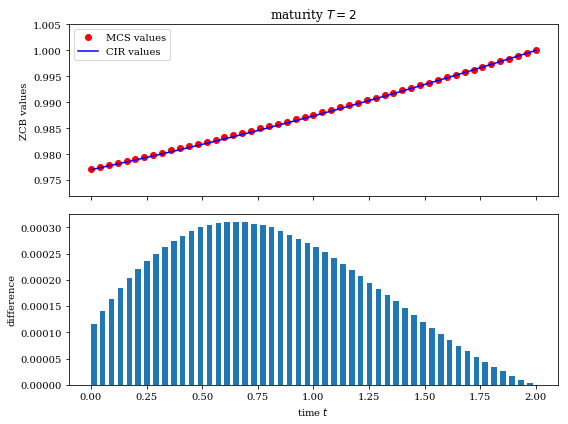

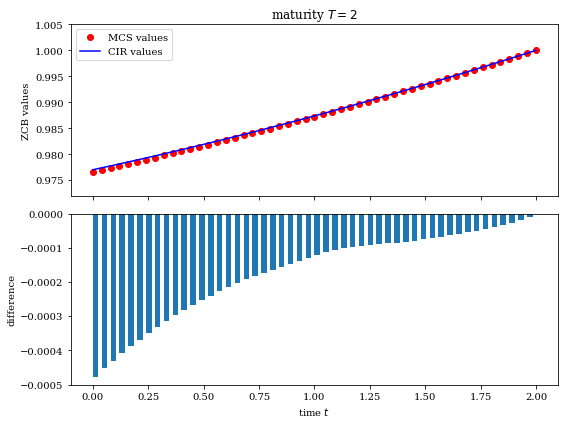

In [120]:
r = CIR_generate_paths(r0, kappa_r, theta_r, sigma_r, T, M, I)
graphical_comparison()
graphical_comparison(x_disc='a')

In [121]:
'''通过误差比较两种定价方法'''
def diffrence_comparison(M=50, x_disc='exact'):
    MCS_values = zcb_estimator(M, x_disc)
    CIR_values = []
    dt = T / M
    t_list = np.arange(0.0, T + 0.001, dt)  # dates of interest
    
    #使用解析法完成模拟路径上个点的定价
    for t in t_list:
        alpha = r0, kappa_r, theta_r, sigma_r, t, T
        CIR_values.append(B(alpha))
    
    return abs((MCS_values - CIR_values)[0])

In [122]:
diff1=[]
diff2=[]
for i in range(0,1000):
    r = CIR_generate_paths(r0, kappa_r, theta_r, sigma_r, T, M, I)
    diff1.append(diffrence_comparison())
    diff2.append(diffrence_comparison(x_disc='a'))

In [123]:
np_diff1=np.array(diff1)
np_diff2=np.array(diff2)
print(np.mean(np_diff1))
print(np.mean(np_diff2))

0.00010925009589135692
0.0002718734976783842
